# 02 - GLMs for Classification
GLMs make excellent, flexible statistical models.  However, they also excel at making classification algorithms.  The purpose of this notebook is to illustrate how this might be done in R.

I give three examples of how GLMs may be used for classification:
* Logistic regression
* Multinomial logistic regression
* Cumulative logistic regression

In [30]:
options(repr.plot.width = 5, repr.plot.height = 3)
library(ggplot2)
library(VGAM)
library(dplyr)

In [6]:
install.packages('dplyr', repos = "http://cran.us.r-project.org")

Installing package into 'C:/Users/Timothy/R/win-library/3.3'
(as 'lib' is unspecified)
also installing the dependencies 'bindr', 'assertthat', 'bindrcpp', 'glue', 'pkgconfig', 'plogr'



package 'bindr' successfully unpacked and MD5 sums checked
package 'assertthat' successfully unpacked and MD5 sums checked
package 'bindrcpp' successfully unpacked and MD5 sums checked
package 'glue' successfully unpacked and MD5 sums checked
package 'pkgconfig' successfully unpacked and MD5 sums checked
package 'plogr' successfully unpacked and MD5 sums checked
package 'dplyr' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Timothy\AppData\Local\Temp\RtmpUxN6MG\downloaded_packages


### Logistic Regression for Classification
#### Data:
For this example, I use the same data set from part 01: the `grad` data.  This is from [UCLA's IDRE module](https://stats.idre.ucla.edu/r/dae/logit-regression/), and here's its description:

 _A researcher is interested in how variables, such as GRE (Graduate Record Exam scores), GPA (grade point average) and prestige of the undergraduate institution, effect admission into graduate school. The response variable, admit/don’t admit, is a binary variable._

In [35]:
grad = read.csv("https://stats.idre.ucla.edu/stat/data/binary.csv")

In [36]:
table(grad$admit)


  0   1 
273 127 

In [38]:
# Create a training/test split
set.seed(1234)
n_train <- 100
index_train <- sample(1:nrow(iris), n_train, replace = FALSE)
grad_train <- grad[index_train,]
grad_test <- grad[-index_train,]

In [39]:
# Produce the same model
glm_logit <- glm(admit ~ gre + gpa + rank, data = grad_train, family = binomial)
summary(glm_logit)


Call:
glm(formula = admit ~ gre + gpa + rank, family = binomial, data = grad_train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.9378  -0.7644  -0.4646   0.9375   2.3371  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.163788   2.303155  -0.071  0.94331    
gre          0.006096   0.002436   2.502  0.01234 *  
gpa         -0.566717   0.721434  -0.786  0.43214    
rank        -0.887582   0.253785  -3.497  0.00047 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 128.21  on 99  degrees of freedom
Residual deviance: 105.59  on 96  degrees of freedom
AIC: 113.59

Number of Fisher Scoring iterations: 4


In [40]:
# Predict training/test response
yhat_train <- fitted(glm_logit)
yhat_test <- predict(glm_logit, grad_test)

head(yhat_train)

18         93         91         92        126        149 
0.11078101 0.67428101 0.53934025 0.78157432 0.08803982 0.55614706

In [41]:
# Convert probabilities to "success"/"failure"s.
p_thresh <- 0.5

yhat_train <- (yhat_train > p_thresh) * 1
yhat_test <- (yhat_test > p_thresh) * 1

table(yhat_train)

yhat_train
 0  1 
73 27 

In [42]:
# Training classification error
mean(yhat_train == grad_train$admit)

[1] 0.75

In [43]:
# Testing classification error
mean(yhat_test == grad_test$admit)

[1] 0.69

### Multinomial Logistic Regression
Using GLMs to classify is not limited to binomial response data.  The multinomial distribution can be used to help classify a response variable with more than 2 levels (also known as "polytomous data").

Recall the formal definition of a K-class multinomial logistic regression:

$Y_i \sim \text{iid Mult}(1, \mathbf{\pi})$

$\log\left(\frac{p_1}{p_K}\right) = \beta_{01} + \beta_{11} x_1 + \cdots + \beta_{p1} x_p$

$\log\left(\frac{p_2}{p_K}\right) = \beta_{02} + \beta_{12} x_1 + \cdots + \beta_{p2} x_p$

$\cdots$

$\log\left(\frac{p_{K-1}}{p_K}\right) = \beta_{0K-1} + \beta_{1K-1} x_1 + \cdots + \beta_{pK-1} x_p$

#### Data
This time, I'm using the classic `iris` dataset.  In Python, this public-domain dataset can be found in the `seaborn` plotting package.  The data consist of four flower characteristcs, and the response variable, flower type.  There are 3 classes this can take.

In [44]:
data(iris)
head(iris)

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
1,5.1,3.5,1.4,0.2,setosa
2,4.9,3,1.4,0.2,setosa
3,4.7,3.2,1.3,0.2,setosa
4,4.6,3.1,1.5,0.2,setosa
5,5,3.6,1.4,0.2,setosa
6,5.4,3.9,1.7,0.4,setosa


In [45]:
# The class is the species variable.  There are 3 species.
table(iris$Species)


    setosa versicolor  virginica 
        50         50         50 

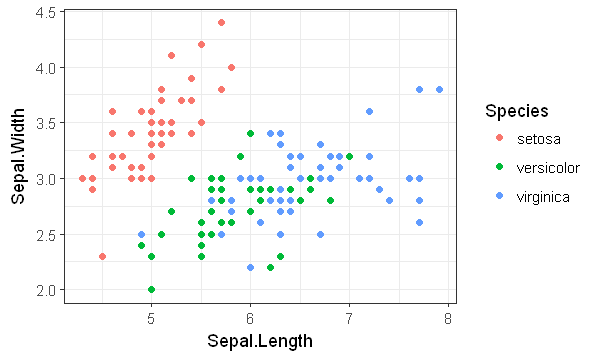

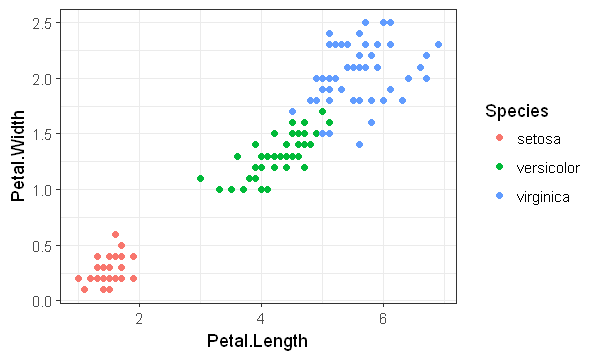

In [46]:
# Notice that this variable visually appears to be very easy to predict.
ggplot(iris, aes(Sepal.Length, Sepal.Width)) +
    theme_bw() +
    geom_point(aes(color = Species))

ggplot(iris, aes(Petal.Length, Petal.Width)) +
    theme_bw() +
    geom_point(aes(color = Species))

### The VGAM Package
Everything you need in order to perform multinomial (and cumulative) logistic regression is in the `VGAM` package.  VGAM stands for **v**ector **g**eneralized **a**dditive **m**odels.  The function we'll use here is `vglm()` (vector GLMs).

In [48]:
# Train/Test split
n_train <- 100
index_train <- sample(1:nrow(iris), n_train, replace = FALSE)

iris_train <- iris[index_train,]
iris_test <- iris[-index_train,]

In [55]:
# Train the model.
# I am supressing warnings because there are many computational warnings.
# The primary one being fitted values being set to 0 or 1.
suppressWarnings({
    multi_glm <- vglm(Species ~ Sepal.Length + Sepal.Width,
                      data = iris_train,
                      family = multinomial)
})

summary(multi_glm)


Call:
vglm(formula = Species ~ Sepal.Length + Sepal.Width, family = multinomial, 
    data = iris_train)


Pearson residuals:
                      Min         1Q     Median        3Q     Max
log(mu[,1]/mu[,3]) -1.080  5.882e-13  7.926e-13 3.853e-08 0.08078
log(mu[,2]/mu[,3]) -3.243 -4.791e-01 -2.441e-06 5.889e-01 2.15419

Coefficients: 
               Estimate Std. Error z value Pr(>|z|)    
(Intercept):1  112.2929   142.0932   0.790  0.42937    
(Intercept):2   12.5344     3.6380   3.445  0.00057 ***
Sepal.Length:1 -38.9931    48.0339  -0.812  0.41692    
Sepal.Length:2  -1.5787     0.5784  -2.729  0.00634 ** 
Sepal.Width:1   30.8706    43.4151   0.711  0.47705    
Sepal.Width:2   -0.9432     1.0492  -0.899  0.36868    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Number of linear predictors:  2 

Names of linear predictors: log(mu[,1]/mu[,3]), log(mu[,2]/mu[,3])

Residual deviance: 76.7433 on 194 degrees of freedom

Log-likelihood: -38.3717 on 194 degrees of 

In [62]:
yhat_train <- predict(multi_glm, iris_train, type = 'response')
yhat_test <- predict(multi_glm, iris_test, type = 'response')
head(yhat_train)

Warning message:
In object@family@linkinv(predictor, extra = new.extra): fitted probabilities numerically 0 or 1 occurred

,setosa,versicolor,virginica
100,1.752642e-11,7.098762e-01,2.901238e-01
79,4.609823e-15,5.809924e-01,4.190076e-01
47,1.000000e+00,1.100562e-13,4.479908e-14
113,5.035555e-27,2.629984e-01,7.370016e-01
77,9.944245e-30,3.011557e-01,6.988443e-01
107,0.01597185,0.90518760,0.07884055


In [65]:
# Perfect!  Fitted values are indeed probabilities.
table(rowSums(yhat_train))


  1 
100 

In [77]:
# Select the maximum probability row-wise.
train_class <- apply(as.matrix(yhat_train), 1, which.max)
test_class <- apply(as.matrix(yhat_test), 1, which.max)

table(train_class)

train_class
 1  2  3 
32 36 32 

In [78]:
# Let's revert the integer classes back into word-classes.
class_lookup <- c('1' = 'setosa',
                  '2' = 'versicolor',
                  '3' = 'virginica')

train_class <- class_lookup[train_class]
test_class <- class_lookup[test_class]

table(train_class)

train_class
    setosa versicolor  virginica 
        32         36         32 

In [83]:
cat('Correctly classified: ', sum(train_class == iris_train$Species), '\n')
cat('Total training data: ', nrow(iris_train), '\n')
cat('Training classification accuracy rate: ', mean(train_class == iris_train$Species))

Correctly classified:  82 
Total training data:  100 
Training classification accuracy rate:  0.82

In [84]:
cat('Correctly classified: ', sum(test_class == iris_test$Species), '\n')
cat('Total testing data: ', nrow(iris_test), '\n')
cat('Training classification accuracy rate: ', mean(test_class == iris_test$Species))

Correctly classified:  41 
Total testing data:  50 
Training classification accuracy rate:  0.82